# Loading Images Using tf.Data.Dataset

**Learning Objectives**

1. Retrieve Images using tf.keras.utils.get_file
2. Load Images using Keras Pre-Processing
3. Load Images using tf.Data.Dataset
4. Understand basic Methods for Training

## Introduction 

In this notebook, we load an image dataset using tf.data.  The dataset used in this example is distributed as directories of images, with one class of image per directory.


Each learning objective will correspond to a **#TODO** in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/load_images_tf.data.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

## Setup

## Load necessary libraries 
We will start by importing the necessary libraries for this lab.

In [1]:
# Importing numpy, a data processing and an image module I/O libraries
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  1.15.0


In [2]:
# It contains experimental Dataset sources and transformations that can be used in conjunction with the tf.data.Dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [3]:
# Importing pathlib to import necessary set of images
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 163s 1us/step


After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [4]:
# Print the image count
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
# Here, np.array() method creates an array
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

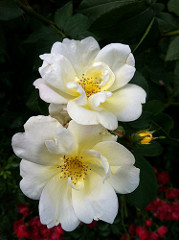

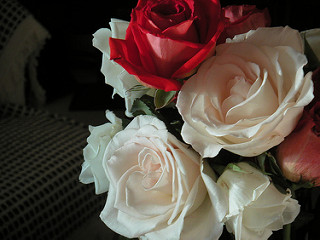

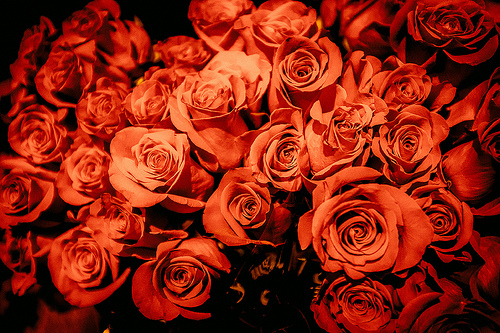

In [6]:
# Here, Image.open() method Opens and identifies the given image file.
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [7]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # TODO 1a

Define some parameters for the loader:

In [8]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [9]:
# Generate batches of tensor image data with real-time data augmentation.
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspect a batch:

In [10]:
# Here, define show_batch() procedure for Inspecting a batch.
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1) # TODO 1b
      plt.imshow(image_batch[n]) # TODO 1b
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

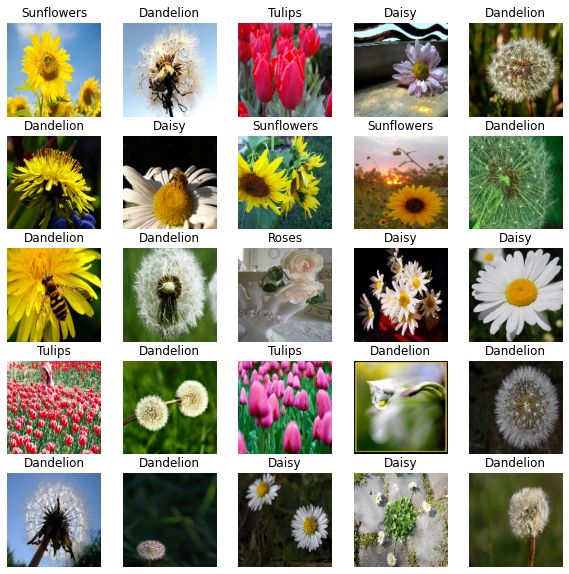

In [11]:
# Here, next() function returns the next item in an iterator.
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [13]:
# Here, .take() method return elements from array along the mentioned axis and indices.
for f in list_ds.take(5):
  print(f.numpy())

RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.

Write a short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep) # TODO 2a
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES # TODO 2a

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3) # TODO 2b
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32) # TODO 2b
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path) # TODO 2c
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
# Print the value of `Image shape` and `Label`
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

### Next Steps:  Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size) # TODO 3a

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
# Here, the next() function returns the next item in an iterator.
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
# Here, we define show_batch() procedure for Inspecting a batch
show_batch(image_batch.numpy(), label_batch.numpy())

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.